In [32]:
!pip install dagshub mlflow

In [33]:
import dagshub
dagshub.init(repo_owner='AleksandreBakhtadze', repo_name='ML-abakh22-assignment-2-IEEE-CIS-Fraud-Detection', mlflow=True)

Initialized MLflow to track repo "AleksandreBakhtadze/ML-abakh22-assignment-2-IEEE-CIS-Fraud-Detection"

Repository AleksandreBakhtadze/ML-abakh22-assignment-2-IEEE-CIS-Fraud-Detection initialized!

In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [35]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

In [36]:
train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')

In [37]:
train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')

In [38]:
test_df = test_transaction.merge(test_identity, on='TransactionID', how='left')

In [39]:
test_df.columns = test_df.columns.str.replace(r'^id-(\d+)', r'id_\1', regex=True)

# To see how imbalance is the data

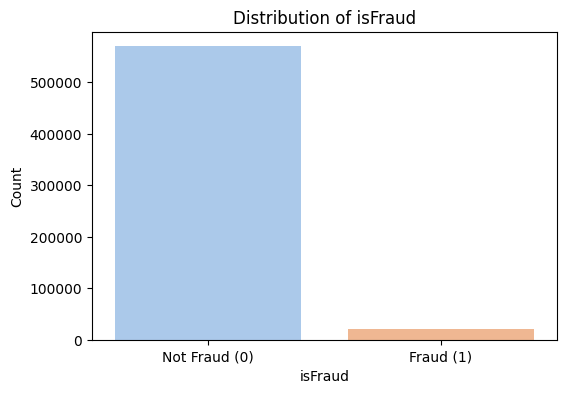

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

# 1. Count the values of isFraud
fraud_counts = train_df['isFraud'].value_counts()

# 2. Create the plot
plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='pastel')

plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])
plt.ylabel('Count')
plt.title('Distribution of isFraud')

# 3. Save the plot
fraud_dist_plot_path = "/kaggle/working/isfraud_distribution.png"
plt.savefig(fraud_dist_plot_path)
plt.show()

# WOE and OHE

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3, extra_cat_cols=None):
        self.threshold = threshold
        self.extra_cat_cols = extra_cat_cols if extra_cat_cols is not None else []

    def fit(self, X, y):
        # Identify categorical columns
        cat_cols = [col for col in X.columns if X[col].dtype == 'object'] + self.extra_cat_cols
        s = X[cat_cols].nunique()
        self.woe_columns = list(s[s > self.threshold].index)
        self.one_hot_columns = list(s[s <= self.threshold].index)

        # Ensure no overlap and valid columns
        self.woe_columns = [col for col in self.woe_columns if col in X.columns]
        self.one_hot_columns = [col for col in self.one_hot_columns if col in X.columns]

        # Generate fill NaN values for WoE columns
        self.woe_columns_fill_na = X[self.woe_columns].mode().T[0].to_dict()
        
        df_woe = X.copy()
        target_col = 'target'
        df_woe[target_col] = y

        woe_mappings = {}
        iv_values = {}
        
        for col in self.woe_columns:
            groups = df_woe.groupby([col])[target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            groups['iv'] = (groups['prop_pos'] - groups['prop_neg']) * groups['woe']
            
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            
            woe_dict = groups['woe'].to_dict()
            iv = groups['iv'].sum()
            
            woe_mappings[col] = woe_dict
            iv_values[col] = iv

        self.woe_mappings = woe_mappings
        self.iv_values = iv_values
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.woe_columns:
            X_transformed[f'{col}_woe'] = X_transformed[col].map(self.woe_mappings[col])
            X_transformed.drop(columns=col, inplace=True)

        X_transformed = pd.get_dummies(X_transformed, columns=self.one_hot_columns, drop_first=True, dummy_na=True, dtype=int)

        n = X_transformed.isna().mean()
        na_cols = list(n[n > 0].index)
        if na_cols:
            print(f"Columns with NaNs after transformation: {na_cols}")
            for col in na_cols:
                if col.endswith('_woe'):
                    name = col.replace('_woe', '')
                    if name in self.woe_columns_fill_na:
                        X_transformed[col] = X_transformed[col].fillna(
                            self.woe_mappings[name].get(self.woe_columns_fill_na[name], 0)
                        )
                    else:
                        X_transformed[col] = X_transformed[col].fillna(0)
                else:
                    X_transformed[col] = X_transformed[col].fillna(0)
        
        return X_transformed

# Missingness and Imputation. Impute all with 999. Do more complex imputation afterwards. 

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

class MissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.99, fill_value=999):
        self.threshold = threshold
        self.fill_value = fill_value
        self.cols_to_drop = []

    def fit(self, X, y=None):
        missing_ratio = X.isnull().mean()
        self.cols_to_drop = missing_ratio[missing_ratio > self.threshold].index.tolist()
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy.drop(columns=self.cols_to_drop, inplace=True, errors='ignore')
        X_copy.fillna(self.fill_value, inplace=True)
        return X_copy


# TransactionDT - Timedelta from a given reference DateTime 
# The 'hour' turns out to be a highly important feature in prediction.

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import os
from sklearn.base import BaseEstimator, TransformerMixin

class TransactionFeaturesExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column='TransactionDT', plot=False):
        self.column = column
        self.plot = plot

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Create Transaction_hour
        if self.column in X_copy.columns:
            X_copy['Transaction_hour'] = (X_copy[self.column] // 3600) % 24

            # Create hour_warning_signal
            def get_warning_signal(hour):
                if 7 < hour < 10:
                    return 'high'
                elif 14 < hour < 16:
                    return 'lowest'
                elif (4 < hour < 7) or (10 < hour < 14):
                    return 'medium'
                else:
                    return 'low'

            X_copy['hour_warning_signal'] = X_copy['Transaction_hour'].apply(get_warning_signal)
        
        # Plot if requested
        if self.plot:
            self.plot_transaction_stats(X_copy)
        
        return X_copy

    def plot_transaction_stats(self, X):
        if 'Transaction_hour' not in X.columns or 'isFraud' not in X.columns:
            print("Columns 'Transaction_hour' and 'isFraud' are required for plotting.")
            return
        
        # Group data by hour
        transactions_by_hour = X.groupby('Transaction_hour').size()
        frauds_by_hour = X.groupby('Transaction_hour')['isFraud'].mean()
        
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Bar plot for total transactions
        ax1.bar(transactions_by_hour.index, transactions_by_hour.values, color='skyblue', alpha=0.7, label='Total transactions')
        ax1.set_xlabel('Hour of the day')
        ax1.set_ylabel('Number of transactions')
        ax1.set_title('Number of Transactions and Fraud Rate by Hour of the Day')
        
        # Line plot for fraud rate
        ax2 = ax1.twinx()
        ax2.plot(frauds_by_hour.index, frauds_by_hour.values, color='red', label='Fraction of fraudulent transactions')
        ax2.set_ylabel('Fraction of fraudulent transactions')

        # Legends
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        # Save the plot locally
        plot_path = "transaction_stats_plot.png"
        plt.savefig(plot_path)
        plt.show()

        # Log the plot to MLflow
        if mlflow.active_run() is not None:
            mlflow.log_artifact(plot_path, artifact_path="plots")

        # Optional: Clean up the file after logging
        if os.path.exists(plot_path):
            os.remove(plot_path)


# PCA for V columns

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

class VPCAExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=30, plot=False):
        self.n_components = n_components
        self.plot = plot
        self.v_cols = [f'V{i}' for i in range(1, 340)]
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=self.n_components)

    def fit(self, X, y=None):
        X_v = X[self.v_cols].fillna(999)
        X_scaled = self.scaler.fit_transform(X_v)
        self.pca.fit(X_scaled)

        if self.plot:
            self.plot_explained_variance()
        
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Handle missing V columns safely
        missing_cols = [col for col in self.v_cols if col not in X_copy.columns]
        if missing_cols:
            raise ValueError(f'Missing V columns in input: {missing_cols}')

        X_v = X_copy[self.v_cols].fillna(999)
        X_scaled = self.scaler.transform(X_v)
        X_pca = self.pca.transform(X_scaled)

        v_pca_df = pd.DataFrame(X_pca, columns=[f'V_PCA_{i+1}' for i in range(self.n_components)], index=X_copy.index)

        X_copy.drop(columns=self.v_cols, inplace=True)
        X_copy = pd.concat([X_copy, v_pca_df], axis=1)

        return X_copy

    def plot_explained_variance(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, self.n_components + 1), self.pca.explained_variance_ratio_, marker='o', linestyle='--')
        plt.title('Explained Variance by Principal Components')
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.grid(True)

        # Save and log plot
        plot_path = "explained_variance_plot.png"
        plt.savefig(plot_path)
        plt.show()

        if mlflow.active_run() is not None:
            mlflow.log_artifact(plot_path, artifact_path="plots")

        if os.path.exists(plot_path):
            os.remove(plot_path)

    def plot_2d_pca_scatter(self, X=None):
        if X is None:
            print("No data provided for 2D PCA scatter plot.")
            return
        
        if self.n_components < 2:
            print("Need at least 2 components for 2D scatter plot.")
            return
        
        X_v = X[self.v_cols].fillna(999)
        X_scaled = self.scaler.transform(X_v)
        X_pca = self.pca.transform(X_scaled)
        
        plt.figure(figsize=(8, 6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
        plt.title('2D Scatter Plot of First Two Principal Components')
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.grid(True)

        # Save and log plot
        plot_path = "pca_2d_scatter_plot.png"
        plt.savefig(plot_path)
        plt.show()

        if mlflow.active_run() is not None:
            mlflow.log_artifact(plot_path, artifact_path="plots")

        if os.path.exists(plot_path):
            os.remove(plot_path)


In [45]:
from sklearn.model_selection import train_test_split

# Check if log_TransactionAmt exists in train_df
columns_to_drop = ['isFraud']

# Prepare features and target
X = train_df.drop(columns=columns_to_drop, axis=1)
y = train_df['isFraud']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Columns 'Transaction_hour' and 'isFraud' are required for plotting.


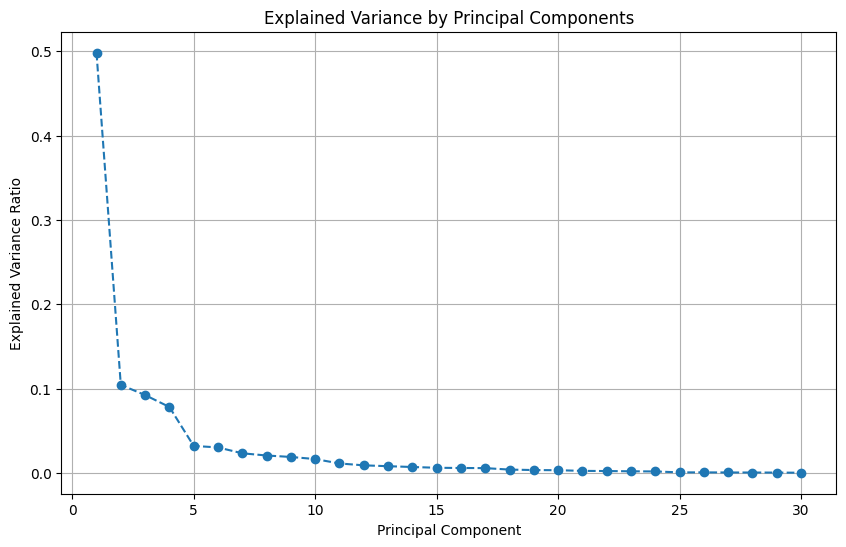

[LightGBM] [Info] Number of positive: 11571, number of negative: 319131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16693
[LightGBM] [Info] Number of data points in the train set: 330702, number of used features: 133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317100
[LightGBM] [Info] Start training from score -3.317100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

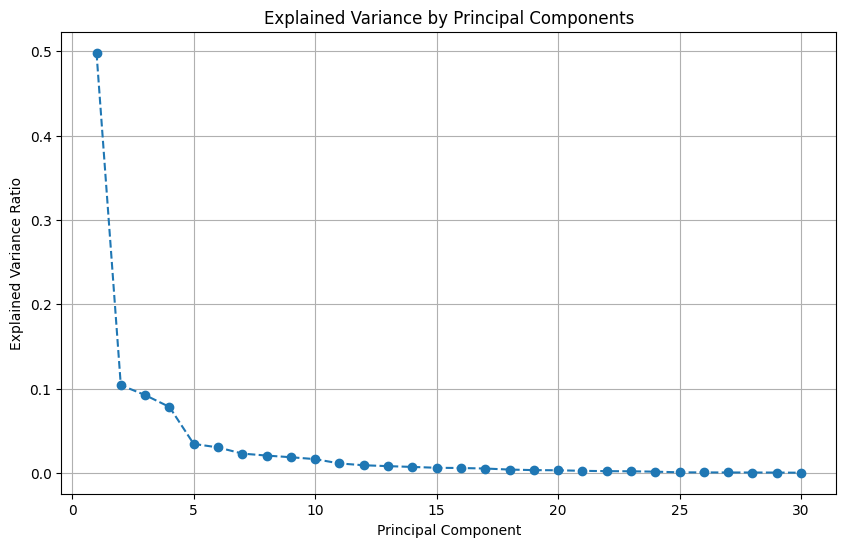

[LightGBM] [Info] Number of positive: 11571, number of negative: 319131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16671
[LightGBM] [Info] Number of data points in the train set: 330702, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317100
[LightGBM] [Info] Start training from score -3.317100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

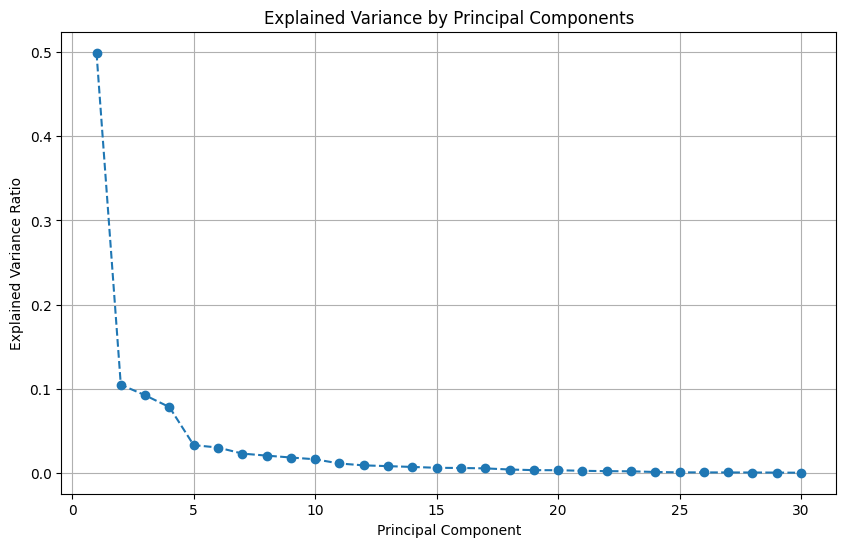

[LightGBM] [Info] Number of positive: 11571, number of negative: 319131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16683
[LightGBM] [Info] Number of data points in the train set: 330702, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317100
[LightGBM] [Info] Start training from score -3.317100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

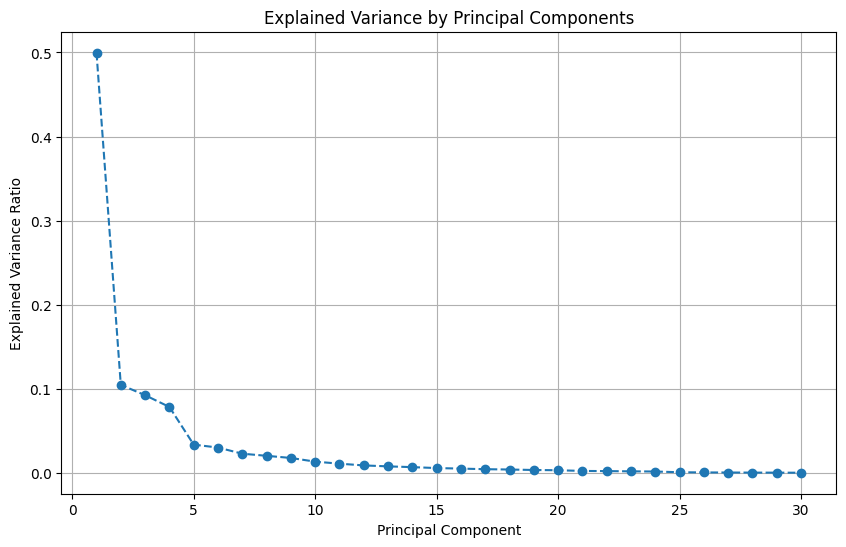

[LightGBM] [Info] Number of positive: 11572, number of negative: 319131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16680
[LightGBM] [Info] Number of data points in the train set: 330703, number of used features: 133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034992 -> initscore=-3.317013
[LightGBM] [Info] Start training from score -3.317013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

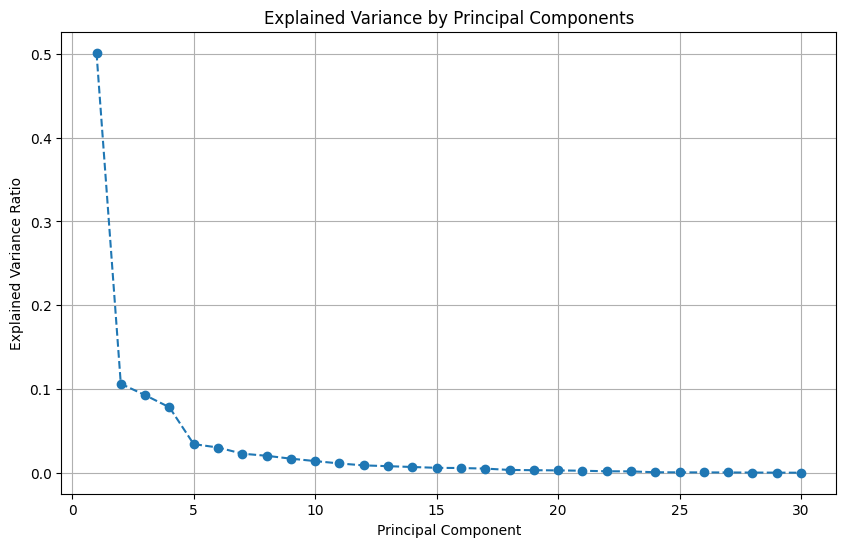

[LightGBM] [Info] Number of positive: 11571, number of negative: 319132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.163732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16683
[LightGBM] [Info] Number of data points in the train set: 330703, number of used features: 133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317103
[LightGBM] [Info] Start training from score -3.317103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

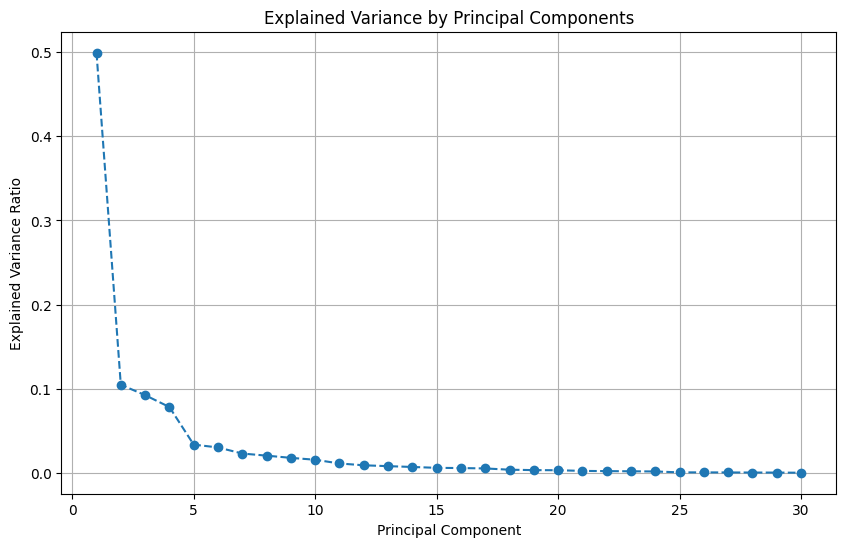

[LightGBM] [Info] Number of positive: 14464, number of negative: 398914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.194697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16726
[LightGBM] [Info] Number of data points in the train set: 413378, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034990 -> initscore=-3.317083
[LightGBM] [Info] Start training from score -3.317083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

2025/04/27 00:31:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


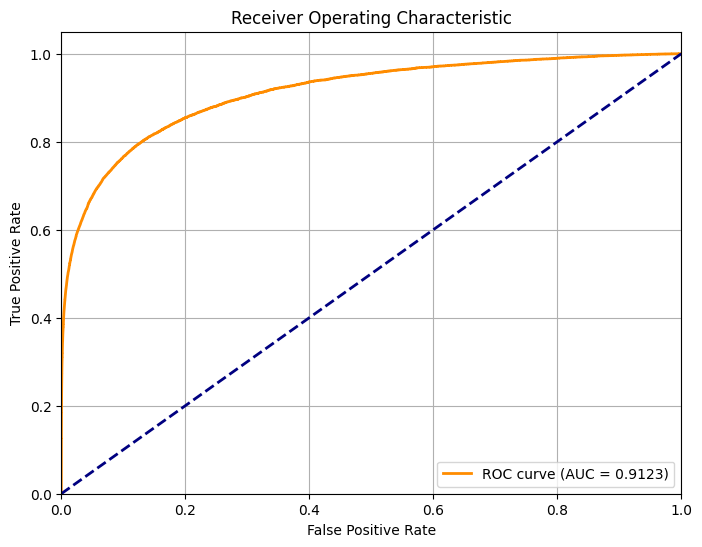

🏃 View run burly-deer-168 at: https://dagshub.com/AleksandreBakhtadze/ML-abakh22-assignment-2-IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/f780224af0af4a94ad64af8e3c076f15
🧪 View experiment at: https://dagshub.com/AleksandreBakhtadze/ML-abakh22-assignment-2-IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0


In [46]:
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score
from lightgbm import LGBMClassifier

# Step 1: Function to calculate imbalance ratio
def calculate_scale_pos_weight(y):
    n_non_fraud = (y == 0).sum()
    n_fraud = (y == 1).sum()
    return n_non_fraud / n_fraud if n_fraud > 0 else 1

# Step 2: Calculate scale_pos_weight
scale_pos_weight = calculate_scale_pos_weight(y_train)

# Step 3: Build the pipeline
full_pipeline = Pipeline([
    ('transaction_features', TransactionFeaturesExtractor(column='TransactionDT', plot=True)),
    ('missing_handler', MissingValueHandler(threshold=0.99, fill_value=999)),
    ('custom_preprocessor', CustomPreprocessor(threshold=3)),
    ('v_pca_extractor', VPCAExtractor(n_components=30, plot=True)),
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(
        objective='binary',
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        scale_pos_weight=scale_pos_weight
    ))
])

# Step 4: Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 5: MLflow logging
with mlflow.start_run():

    oof_preds = []
    oof_true = []

    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        full_pipeline.fit(X_tr, y_tr)
        preds = full_pipeline.predict_proba(X_val)[:, 1]

        oof_preds.extend(preds)
        oof_true.extend(y_val)

    # Step 6: Metrics
    fpr, tpr, thresholds = roc_curve(oof_true, oof_preds)
    roc_auc = auc(fpr, tpr)

    pred_labels = np.array(oof_preds) >= 0.5

    f1 = f1_score(oof_true, pred_labels)
    precision = precision_score(oof_true, pred_labels)
    recall = recall_score(oof_true, pred_labels)
    accuracy = accuracy_score(oof_true, pred_labels)

    # Print metrics
    print(f"Mean ROC AUC: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    # Log metrics
    mlflow.log_metric('roc_auc', roc_auc)
    mlflow.log_metric('f1_score', f1)
    mlflow.log_metric('precision', precision)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('accuracy', accuracy)

    # Step 7: Log model parameters
    clf = full_pipeline.named_steps['classifier']
    clf_params = clf.get_params()
    for param_name, param_value in clf_params.items():
        mlflow.log_param(param_name, param_value)

    # Step 8: Fit on full data and log model
    full_pipeline.fit(X_train, y_train)
    mlflow.sklearn.log_model(full_pipeline, artifact_path="lgbm_pipeline_model")

    # Step 9: Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid()

    roc_plot_path = "roc_curve_pipeline_plot.png"
    plt.savefig(roc_plot_path)
    plt.show()

    if mlflow.active_run() is not None:
        mlflow.log_artifact(roc_plot_path, artifact_path="plots")

    if os.path.exists(roc_plot_path):
        os.remove(roc_plot_path)

Columns 'Transaction_hour' and 'isFraud' are required for plotting.


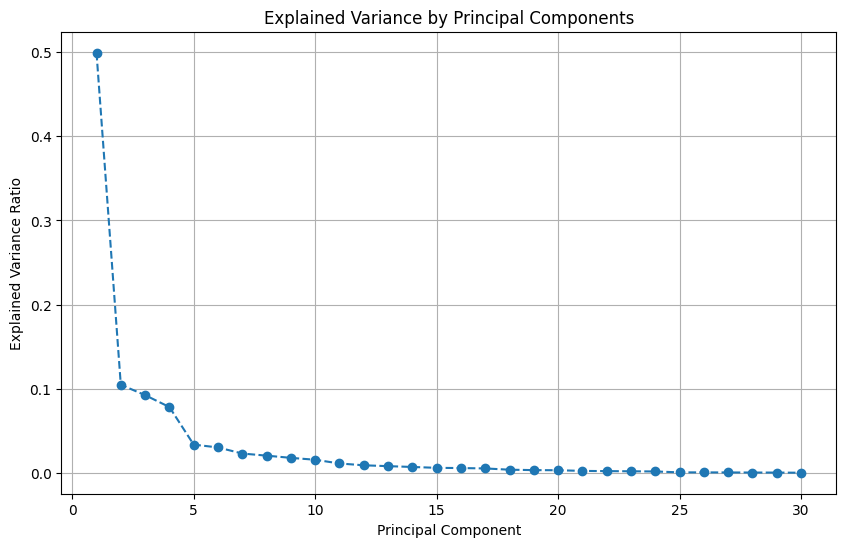

[LightGBM] [Info] Number of positive: 14464, number of negative: 398914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16726
[LightGBM] [Info] Number of data points in the train set: 413378, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034990 -> initscore=-3.317083
[LightGBM] [Info] Start training from score -3.317083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [47]:
full_pipeline.fit(X_train, y_train)

# Predict probabilities on test_df
y_test_pred_proba = full_pipeline.predict_proba(test_df)[:, 1]

submission = pd.read_csv("/kaggle/input/ieee-fraud-detection/sample_submission.csv")

submission = pd.DataFrame({
    'TransactionID': test_df['TransactionID'],
    'isFraud': y_test_pred_proba
})

# Save submission CSV
submission.to_csv('submission.csv', index=False)

# Verify submission format
print(submission.head())